# STM Transit Delay Data Preparation

## Overview

This notebook merges data from different sources and prepares it for data analysis.

## Data description

### Real-time Trip Updates

`current_time` timestamp when the data was collected<br>
`trip_id` unique identifier of a trip<br>
`route_id` bus line<br>
`start_date` start date of the trip<br>
`stop_id` stop number<br>
`arrival_time` actual arrival time, in milliseconds<br>
`departure_time` actual departure time, in milliseconds<br>
`schedule_relationship` state of the trip, 0 means scheduled and 1 means skipped

### Scheduled STM Trips

`trip_id` unique identifier of a trip<br>
`arrival_time` scheduled arrival time, in milliseconds<br>
`departure_time` scheduled departure time, in milliseconds<br>
`stop_id` stop number<br>
`stop_sequence` sequence of the stop, for ordering

### STM Stops

`stop_id` unique identifier of a stop<br>
`stop_code` bus stop or metro station number<br>
`stop_name` bus stop or metro station name<br>
`stop_lat` stop latitude<br>
`stop_lon` stop longitude<br>
`stop_url` stop web page<br>
`location_type` stop type<br>
`parent_station` parent station (metro station with multiple exits)<br>
`wheelchair_boarding` indicates if the stop is accessible for people in wheelchair, 1 being true and 2 being false

### Real-time Vehicle Positions

`current_time` timestamp when the data was collected<br>
`vehicle_id` unique identifuer of a vehicle<br>
`trip_id` unique identifier of a trip<br>
`route_id` bus or metro line<br>
`start_date` start date of a trip<br>
`start_time` start time of a trip<br>
`latitude` vehicle current latitude<br>
`longitude` vehicle current longityde<br>
`bearing` direction that the vehicle is facing<br>
`speed` momentary speed measured by the vehicle, in meters per second<br>
`stop_sequence` sequence of the stop, for ordering<br>
`status` vehicle stop status in relation with a stop that it's currently approaching or is at<br>
`timestamp` timestamp when STM updated the data<br>
`occupancy_status` degree of passenger occupancy

### Weather Archive and Forecast

`time` date and hour or the weather<br>
`temperature` air temperature at 2 meters above ground, in Celsius<br>
`precipitation` total precipitation (rain, showers, snow) sum of the preceding hour, in millimeters<br>
`windspeed` wind speed at 10 meters above ground, in km/h<br>
`weathercode` World Meteorological Organization (WMO) code

### Traffic Incidents

`category` category of the incident<br>
`start_time` start time of the incident in ISO8601 format<br>
`end_time` end time of the incident in ISO8601 format<br>
`length` length of the incident in meters<br>
`delay` delay in seconds caused by the incident (except road closures)<br>
`magnitude_of_delay` severity of the delay<br>
`last_report_time` date in ISO8601 format, when the last time the incident was reported<br>
`latitude` latitude of the incident<br>
`longitude` longitude of the incident

## Imports

In [1]:
from datetime import datetime, timedelta, timezone
from haversine import haversine, Unit
import matplotlib.pyplot as plt
import pandas as pd
import sys

In [2]:
# Import custom code
sys.path.insert(0, '..')
from scripts.custom_functions import fetch_weather, LOCAL_TIMEZONE

In [3]:
trips_df = pd.read_csv('../data/api/fetched_stm_trip_updates.csv', low_memory=False)

In [4]:
schedules_df = pd.read_csv('../data/download/stop_times_2025-04-30.txt')

In [5]:
stops_df = pd.read_csv('../data/download/stops_2025-04-30.txt')

In [6]:
positions_df =  pd.read_csv('../data/api/fetched_stm_vehicle_positions.csv', low_memory=False)

In [7]:
weather_df = pd.read_csv('../data/api/fetched_historical_weather.csv')

In [8]:
traffic_df = pd.read_csv('../data/api/fetched_traffic.csv')

## Clean Data

In [9]:
# Convert route_id to integer
trips_df['route_id'] = trips_df['route_id'].str.extract(r'(\d+)')
trips_df['route_id'] = trips_df['route_id'].astype('int64')

In [10]:
# Sort trips
trips_df = trips_df.sort_values(by=['current_time', 'trip_id', 'route_id', 'arrival_time'])

In [11]:
# Get proportion of duplicates
subset = ['start_date', 'trip_id', 'route_id', 'stop_id']
duplicate_mask = trips_df.duplicated(subset=subset)
print(f'{duplicate_mask.mean():.2%}')

26.36%


In [12]:
# Remove duplicates
trips_df = trips_df.drop_duplicates(subset=subset, keep='last') # keep latest update

In [13]:
# Convert realtime arrival and departure time to milliseconds
trips_df['arrival_time'] = trips_df['arrival_time'] * 1000
trips_df['departure_time'] = trips_df['departure_time'] * 1000

In [14]:
# Get distribution of realtime arrival times
trips_df[['arrival_time', 'departure_time']].describe()

,arrival_time,departure_time
count,1.870138e+06,1.870138e+06
mean,1.645081e+12,1.641731e+12
std,4.073272e+11,4.136145e+11
min,0.000000e+00,0.000000e+00
25%,1.745860e+12,1.745860e+12
50%,1.745933e+12,1.745933e+12
75%,1.746009e+12,1.746008e+12
max,1.746066e+12,1.746066e+12


In [15]:
# Get proportion of rows with zero arrival times
zero_mask = trips_df['arrival_time'] == 0
print(f'{zero_mask.mean():.2%}')

5.78%


In [16]:
# Get proportion of rows where the arrival and departure times are different
diff_date_mask = trips_df['arrival_time'] != trips_df['departure_time']
print(f'{diff_date_mask.mean():.2%}')

6.08%


In [17]:
# Display rows
trips_df[diff_date_mask].sample(10)

,current_time,trip_id,route_id,start_date,stop_id,arrival_time,departure_time,schedule_relationship
2518477,1.746058e+09,285031432,449,20250430,59312,1746058560000,0,0
2485127,1.746054e+09,285009836,164,20250430,60504,0,1746056520000,0
2264228,1.746040e+09,286571207,101,20250430,61339,1746041480000,0,0
456827,1.745852e+09,284726815,99,20250428,54172,0,1745854200000,0
430269,1.745849e+09,285009262,207,20250428,57821,1745850360000,0,0
1356238,1.745950e+09,284741485,439,20250429,62200,1745952062000,0,0
1412900,1.745953e+09,285007363,117,20250429,55922,1745955473000,0,0
77819,1.745798e+09,283855538,187,20250427,54115,1745801700000,0,0
2105269,1.746025e+09,286571354,102,20250430,50489,0,1746025620000,0
1915268,1.746011e+09,286570265,57,20250430,52069,1746012960000,0,0


In [18]:
# Replace zero arrival times by departure times, as they are usually the same
trips_df.loc[zero_mask, 'arrival_time'] = trips_df.loc[zero_mask, 'departure_time']

In [19]:
# Get proportion of rows with zero arrival times again
zero_mask = trips_df['arrival_time'] == 0
print(f'{zero_mask.mean():.2%}')

3.22%


In [20]:
# Delete the rows with 0 arrival times
trips_df = trips_df[~zero_mask]
zero_mask = trips_df['arrival_time'] == 0
assert zero_mask.sum() == 0

In [21]:
# Rename arrival time
trips_df = trips_df.rename(columns={'arrival_time': 'realtime_arrival_time'})

## Merge Data

### Realtime and Scheduled Trips

In [22]:
# Sort values by stop sequence
schedules_df = schedules_df.sort_values(by=['trip_id', 'stop_sequence'])

In [23]:
# Reset stop sequences (some stops might be missing)
schedules_df['stop_sequence'] = schedules_df.groupby('trip_id').cumcount() + 1

In [24]:
# Add trip progress (vehicles further along the trip are more likely to be delayed)
total_stops = schedules_df.groupby('trip_id')['stop_id'].transform('count')
schedules_df['trip_progress'] = schedules_df['stop_sequence'] / total_stops

In [25]:
# Merge realtime and scheduled trips (#TODO: concatenate new schedule before left joining)
stm_trips_df = pd.merge(left=trips_df, right=schedules_df, how='inner', on=['trip_id', 'stop_id'])

In [26]:
# Convert start_date to datetime
stm_trips_df['start_date_dt'] = pd.to_datetime(stm_trips_df['start_date'], format='%Y%m%d')

In [27]:
def parse_gtfs_time(row) -> pd.Timestamp:
	'''
	Converts GTFS time string (e.g., '25:30:00') to datetime
	based on the arrival time.
	'''
	hours, minutes, seconds = map(int, row['arrival_time'].split(':'))
	total_seconds = hours * 3600 + minutes * 60 + seconds

	parsed_time = row['start_date_dt'] + timedelta(seconds=total_seconds)
	return parsed_time

In [28]:
# Convert planned arrival time to localized datetime
parsed_time = stm_trips_df.apply(parse_gtfs_time, axis=1)
sch_arrival_time = parsed_time.dt.tz_localize(LOCAL_TIMEZONE)

In [29]:
# Convert planned time to timestamp in milliseconds since epoch
stm_trips_df['scheduled_arrival_time'] = sch_arrival_time.astype('int64') // 10**6

In [30]:
# Convert realtime and scheduled arrival time to UTC datetime
stm_trips_df['realtime_arrival_time_dt'] = pd.to_datetime(stm_trips_df['realtime_arrival_time'], origin='unix', unit='ms', utc=True)
stm_trips_df['scheduled_arrival_time_dt'] = pd.to_datetime(stm_trips_df['scheduled_arrival_time'], origin='unix', unit='ms', utc=True)

In [31]:
# Calculate delay in seconds (real - scheduled)
stm_trips_df['delay'] = (stm_trips_df['realtime_arrival_time_dt'] - stm_trips_df['scheduled_arrival_time_dt']).dt.total_seconds()

In [32]:
# Get distribution
stm_trips_df['delay'].describe()

count    1.794175e+06
mean     7.328188e+01
std      4.594433e+02
min     -1.359200e+04
25%      0.000000e+00
50%      0.000000e+00
75%      3.500000e+01
max      5.458500e+04
Name: delay, dtype: float64

There are some extreme delays (~2h15min early to ~5h15min late), which could greatly affect the performance of a predictive model.

### Trips and Stops

In [35]:
trips_stops_df = pd.merge(left=stm_trips_df, right=stops_df, how='inner', left_on='stop_id', right_on='stop_code')

In [36]:
trips_stops_df.columns

Index(['current_time', 'trip_id', 'route_id', 'start_date', 'stop_id_x',
       'realtime_arrival_time', 'departure_time_x', 'schedule_relationship',
       'arrival_time', 'departure_time_y', 'stop_sequence', 'trip_progress',
       'start_date_dt', 'scheduled_arrival_time', 'realtime_arrival_time_dt',
       'scheduled_arrival_time_dt', 'delay', 'stop_id_y', 'stop_code',
       'stop_name', 'stop_lat', 'stop_lon', 'stop_url', 'location_type',
       'parent_station', 'wheelchair_boarding'],
      dtype='object')

In [37]:
# Rename stop id
trips_stops_df = trips_stops_df.rename(columns={'stop_id_x': 'stop_id'})

In [38]:
# Convert wheelchair_boarding to boolean
trips_stops_df['wheelchair_boarding'] = (trips_stops_df['wheelchair_boarding'] == 1).astype('int64')

### Vehicle Positions

In [39]:
# Rename latitude and longitude
positions_df = positions_df.rename(columns={
  'latitude': 'vehicle_lat',
  'longitude': 'vehicle_lon',
  'status': 'vehicle_status',
  'bearing': 'vehicle_bearing',
  'speed': 'vehicle_speed'
})

In [40]:
# Convert vehicle timestamp to datetime
positions_df['vehicle_dt'] = pd.to_datetime(positions_df['timestamp'] * 1000, origin='unix', unit='ms', utc=True)

In [41]:
# Sort values
subset = ['trip_id', 'route_id', 'start_date', 'stop_sequence']
positions_df = positions_df.sort_values(by=subset)

In [42]:
# Get duplicates
duplicate_mask = positions_df.duplicated(subset=subset)
positions_df[duplicate_mask]

,current_time,vehicle_id,trip_id,route_id,start_date,start_time,vehicle_lat,vehicle_lon,vehicle_bearing,vehicle_speed,stop_sequence,vehicle_status,timestamp,occupancy_status,vehicle_dt
136494,1.746045e+09,31001,904429,470,20250430.0,16:03:00,45.489998,-73.729767,284.0,14.44456,2,2,1746045054,3,2025-04-30 20:30:54+00:00
104926,1.746009e+09,41042,905002,41,20250430.0,05:30:00,45.555935,-73.667336,0.0,0.00000,35,2,1746009039,1,2025-04-30 10:30:39+00:00
56821,1.745929e+09,33829,908894,470,20250429.0,07:15:00,45.496933,-73.704300,41.0,3.88892,24,2,1745928932,3,2025-04-29 12:15:32+00:00
15261,1.745852e+09,32802,914104,470,20250428.0,10:24:00,45.459759,-73.891930,144.0,0.00000,3,1,1745852444,1,2025-04-28 15:00:44+00:00
15784,1.745853e+09,32802,914104,470,20250428.0,10:24:00,45.459759,-73.891930,94.0,0.00000,3,1,1745853345,1,2025-04-28 15:15:45+00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110747,1.746014e+09,42026,286749881,69,20250430.0,07:58:00,45.568249,-73.659622,0.0,0.00000,5,2,1746014441,1,2025-04-30 12:00:41+00:00
55689,1.745928e+09,39136,287230574,56,20250429.0,07:29:00,45.618084,-73.581253,0.0,0.00000,16,2,1745928023,1,2025-04-29 12:00:23+00:00
56793,1.745929e+09,39136,287230574,56,20250429.0,07:29:00,45.618450,-73.580353,0.0,0.00000,16,2,1745928937,1,2025-04-29 12:15:37+00:00
57850,1.745930e+09,39136,287230574,56,20250429.0,07:29:00,45.617733,-73.580452,0.0,0.00000,16,2,1745929818,1,2025-04-29 12:30:18+00:00


In [43]:
# Get proportion of duplicates
print(f'{duplicate_mask.mean():.2%}')

3.37%


In [44]:
# Remove duplicates
positions_df = positions_df.drop_duplicates(subset=subset)

In [45]:
# Merge with other STM data
stm_df = pd.merge(left=trips_stops_df, right=positions_df, how='inner', on=['trip_id', 'route_id', 'start_date', 'stop_sequence'])

In [46]:
# Calculate distance between the vehicle and the stop
stm_df['vehicle_distance'] = stm_df.apply(
  lambda row: haversine((row['vehicle_lat'], row['vehicle_lon']), (row['stop_lat'], row['stop_lon']), unit=Unit.METERS),
  axis=1)

In [48]:
stm_df.columns

Index(['current_time_x', 'trip_id', 'route_id', 'start_date', 'stop_id',
       'realtime_arrival_time', 'departure_time_x', 'schedule_relationship',
       'arrival_time', 'departure_time_y', 'stop_sequence', 'trip_progress',
       'start_date_dt', 'scheduled_arrival_time', 'realtime_arrival_time_dt',
       'scheduled_arrival_time_dt', 'delay', 'stop_id_y', 'stop_code',
       'stop_name', 'stop_lat', 'stop_lon', 'stop_url', 'location_type',
       'parent_station', 'wheelchair_boarding', 'current_time_y', 'vehicle_id',
       'start_time', 'vehicle_lat', 'vehicle_lon', 'vehicle_bearing',
       'vehicle_speed', 'vehicle_status', 'timestamp', 'occupancy_status',
       'vehicle_dt', 'vehicle_distance'],
      dtype='object')

In [49]:
stm_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 133075 entries, 0 to 133074
Data columns (total 38 columns):
 #   Column                     Non-Null Count   Dtype              
---  ------                     --------------   -----              
 0   current_time_x             133075 non-null  float64            
 1   trip_id                    133075 non-null  int64              
 2   route_id                   133075 non-null  int64              
 3   start_date                 133075 non-null  int64              
 4   stop_id                    133075 non-null  int64              
 5   realtime_arrival_time      133075 non-null  int64              
 6   departure_time_x           133075 non-null  int64              
 7   schedule_relationship      133075 non-null  int64              
 8   arrival_time               133075 non-null  object             
 9   departure_time_y           133075 non-null  object             
 10  stop_sequence              133075 non-null  int64       

### STM and Weather

In [50]:
# Convert time string to datetime
time_dt = pd.to_datetime(weather_df['time'], utc=True)

In [51]:
# Calculate dates for weather forecast
last_day_weather = time_dt.max()
start_date = last_day_weather + timedelta(days=1)
end_date = stm_df['realtime_arrival_time_dt'].max()

In [52]:
# Fetch forecast weather
start_date_str = start_date.strftime('%Y-%m-%d')
end_date_str = end_date.strftime('%Y-%m-%d')

forecast_list = fetch_weather(start_date=start_date_str, end_date=end_date_str, forecast=True)
forecast_df = pd.DataFrame(forecast_list)

In [53]:
# Merge archive and forecast weather
weather_df = pd.concat([weather_df, forecast_df], ignore_index=True)

In [54]:
# Round arrival time to the nearest hour
stm_df['rounded_arrival_dt'] = stm_df['realtime_arrival_time_dt'].dt.round('h')

In [55]:
# Format time to match weather data
stm_df['time'] = stm_df['rounded_arrival_dt'].dt.strftime('%Y-%m-%dT%H:%M')

In [56]:
# Merge STM with weather
stm_weather_df = pd.merge(left=stm_df, right=weather_df, how='inner', on='time')

### Traffic Data

In [57]:
# Get proportion of duplicates
duplicate_mask = traffic_df.duplicated()
print(f'{duplicate_mask.mean():.2%}')

33.31%


In [58]:
# Remove duplicates
traffic_df = traffic_df.drop_duplicates(keep='last').reset_index()

In [59]:
# Convert traffic start_time and end_time to datetime
traffic_df['start_time_dt'] = pd.to_datetime(traffic_df['start_time'], utc=True)
traffic_df['end_time_dt'] = pd.to_datetime(traffic_df['end_time'], utc=True)

In [60]:
# Sort by date
traffic_df = traffic_df.sort_values(by='start_time_dt').reset_index()

In [61]:
# Fill null end times with current time (assuming the incident is still ongoing)
traffic_df['end_time_dt'] = traffic_df['end_time_dt'].fillna(datetime.now(timezone.utc).replace(microsecond=0))
assert traffic_df['end_time_dt'].isna().sum() == 0

In [62]:
# Build traffic cache (for every 30 min interval)
def build_traffic_cache(traffic_df:pd.DataFrame) -> dict:
	traffic_cache = {}
	traffic_df['half_hour'] = traffic_df['start_time_dt'].dt.floor('30min')

	for (hour, group) in traffic_df.groupby('half_hour'):
		traffic_cache[hour] = group.copy()

	return traffic_cache

Since there are many trip updates on the same day (even the same hour), there's a risk of repeating the filtering of active traffic incidents for each trip individually, which takes a lot of time for a large dataset. Traffic incidents are stable over minutes or hours. This is why the incidents are cached by 30 minute intervals.

In [63]:
def calculate_nearby_incidents(trip_update:pd.Series, traffic_cache:dict, max_distance:int=500) -> pd.Series:
	trip_datetime = trip_update['vehicle_dt']
	stop_coords = (trip_update['vehicle_lat'], trip_update['vehicle_lon'])

	trip_half_hour = trip_datetime.floor('30min')

	# Get cached incidents
	hour_incidents = traffic_cache.get(trip_half_hour)

	# Stop if there are no incidents for that hour
	if hour_incidents is None or hour_incidents.empty:
		return pd.Series({
			'incident_nearby': 0,
			'nearest_incident_distance': None,
			'incident_category': None,
			'incident_delay': None,
			'incident_delay_magnitude': None
		})

	# Filter for active incidents at that trip hour
	active_incidents = hour_incidents[
		(hour_incidents['start_time_dt'] <= trip_datetime) &
		(hour_incidents['end_time_dt'] >= trip_datetime)
	].copy()

	if active_incidents.empty:
		return pd.Series({
			'incident_nearby': 0,
			'nearest_incident_distance': None,
			'incident_category': None,
			'incident_delay': None,
			'incident_delay_magnitude': None
		})

	# Calculate distance     
	active_incidents['distance'] = active_incidents.apply(
		lambda row: haversine(stop_coords, (row['latitude'], row['longitude']), unit=Unit.METERS),
		axis=1
	)

	# Filter nearby
	nearby_incidents = active_incidents[active_incidents['distance'] <= max_distance]

	if nearby_incidents.empty:
		return pd.Series({
			'incident_nearby': 0,
			'nearest_incident_distance': None,
			'incident_category': None,
			'incident_delay': None,
			'incident_delay_magnitude': None
		})
	else:
		nearest = nearby_incidents.loc[nearby_incidents['distance'].idxmin()]
		return pd.Series({
			'incident_nearby': 1,
			'nearest_incident_distance': nearest['distance'],
			'incident_category': nearest['category'],
			'incident_delay': nearest['delay'],
			'incident_delay_magnitude': nearest['magnitude_of_delay']
		})

In [64]:
# Get traffic columns (get incidents within 500 meters)
traffic_cache = build_traffic_cache(traffic_df)
traffic_cols = stm_weather_df.apply(lambda row: calculate_nearby_incidents(row, traffic_cache), axis=1)

In [65]:
# Merge the traffic
df = pd.concat([stm_weather_df, traffic_cols], axis=1)

## Small EDA

In [78]:
# Get correlations of features with delay
correlations = df.corr(numeric_only=True)['delay']
correlations.sort_values(key=abs, ascending=False).head(11)[1:]

stop_sequence             0.096945
trip_progress             0.077900
occupancy_status          0.057247
realtime_arrival_time     0.040380
incident_category         0.039992
current_time_x            0.039358
scheduled_arrival_time    0.036411
current_time_y            0.035891
timestamp                 0.035870
route_id                  0.034096
Name: delay, dtype: float64

In [79]:
# Get proportion of trips that are on time
on_time_mask = df['delay'] == 0
print(f'{(on_time_mask.sum() / len(df)):.2%}')

63.43%


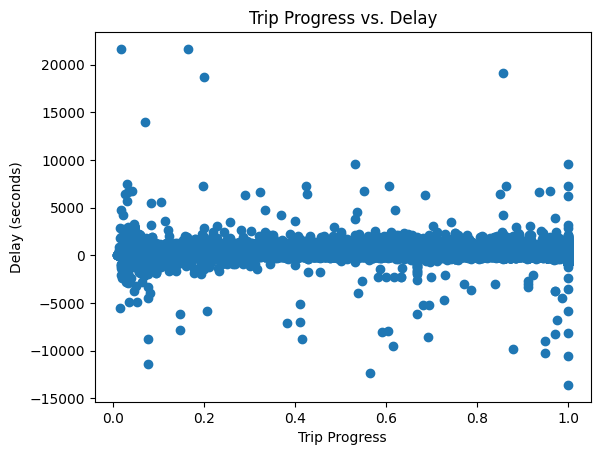

In [80]:
# Plot trip progress vs. delay
plt.scatter(x=df['trip_progress'], y=df['delay'])
plt.title('Trip Progress vs. Delay')
plt.xlabel('Trip Progress')
plt.ylabel('Delay (seconds)')
plt.savefig('../images/trip_progress_vs_delay.png', bbox_inches='tight')
plt.show()

From the plot, it looks like the delay is relatively stable across the trip progress. There are many data points that appear scattered around the x-axis, indicating that delays do not change significantly throughout the trip in many cases. The wide range of delays suggests that delays are highly variable, but there is not clear relationship between trip progress and delay. This could imply that other factors like traffic, accidents, mechanical issues or weather may have more impact on the delays.

## Export Data

In [81]:
# Remove columns with constant values or with more than 50% missing values
df = df.loc[:, (df.nunique() > 1) & (df.isna().mean() < 0.5)]
df.columns

Index(['current_time_x', 'trip_id', 'route_id', 'start_date', 'stop_id',
       'realtime_arrival_time', 'departure_time_x', 'arrival_time',
       'departure_time_y', 'stop_sequence', 'trip_progress', 'start_date_dt',
       'scheduled_arrival_time', 'realtime_arrival_time_dt',
       'scheduled_arrival_time_dt', 'delay', 'stop_id_y', 'stop_code',
       'stop_name', 'stop_lat', 'stop_lon', 'stop_url', 'wheelchair_boarding',
       'current_time_y', 'vehicle_id', 'start_time', 'vehicle_lat',
       'vehicle_lon', 'vehicle_bearing', 'vehicle_speed', 'vehicle_status',
       'timestamp', 'occupancy_status', 'vehicle_dt', 'vehicle_distance',
       'rounded_arrival_dt', 'time', 'temperature', 'precipitation',
       'windspeed', 'weathercode', 'incident_nearby'],
      dtype='object')

In [82]:
# Keep relevant columns
df = df[[
  	'trip_id',
  	'vehicle_id', 
    'vehicle_lat',
    'vehicle_lon',
    'vehicle_distance', # engineered
    'vehicle_status',
    'vehicle_bearing',
    'vehicle_speed',
	'occupancy_status',
  	'route_id',
  	'stop_id',
  	'stop_lat',
  	'stop_lon',
	'stop_sequence',
  	'trip_progress', # engineered
  	'wheelchair_boarding',
  	'realtime_arrival_time',
    'scheduled_arrival_time',
    'delay', # engineered
  	'temperature',
  	'precipitation',
  	'windspeed', 
	'weathercode',
  	'incident_nearby', # engineered
	#'incident_category',
	#'nearest_incident_distance',
	#'incident_delay',
	#'incident_delay_magnitude'
]]

In [83]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 133075 entries, 0 to 133074
Data columns (total 24 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   trip_id                 133075 non-null  int64  
 1   vehicle_id              133075 non-null  int64  
 2   vehicle_lat             133075 non-null  float64
 3   vehicle_lon             133075 non-null  float64
 4   vehicle_distance        133075 non-null  float64
 5   vehicle_status          133075 non-null  int64  
 6   vehicle_bearing         133075 non-null  float64
 7   vehicle_speed           133075 non-null  float64
 8   occupancy_status        133075 non-null  int64  
 9   route_id                133075 non-null  int64  
 10  stop_id                 133075 non-null  int64  
 11  stop_lat                133075 non-null  float64
 12  stop_lon                133075 non-null  float64
 13  stop_sequence           133075 non-null  int64  
 14  trip_progress       

In [84]:
# Export data to CSV
df.to_csv('../data/stm_weather_traffic_merged.csv', index=False)

## End